# Classification

## Get the data

In [1]:
# Fetch the MNIST dataset
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
# The images have 28*28 pixels
28*28

784

## Explore

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

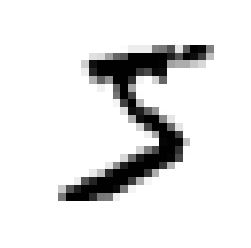

In [12]:
# Show the first image
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [13]:
# Check the label. It is indeed 5 as we see.
y[0]

'5'

In [16]:
import numpy as np

# Change the labels from string to int
y = y.astype(np.uint8)

## Split into test and train set
Since there are 10,000 images, we pick the first 60,000 images as the train set

In [ ]:
X_train, X_test, y_train, y_test = X[:6000], X[60000:], y[:6000], y[6000:]
